# 1D Discontinuous Galerkin Shallow Water Solver

We solve the 1D Shallow Water Equations in conservative form:

\begin{align*}
    h_t + q_x &= 0 \\
    q_t + \left[ \frac{q^2}{h} + \frac{1}{2} g h^2 \right]_x &= -g h b_x - C_f \left(\frac{q}{h}\right)^2
\end{align*}

In this notebook, we neglect friction so that $C_f = 0$.

We begin by importing appropriate libraries, modules, etc. and defining our physical domain. We'll define initial conditions for height and flow and plot these against the system's variable bathymetry:

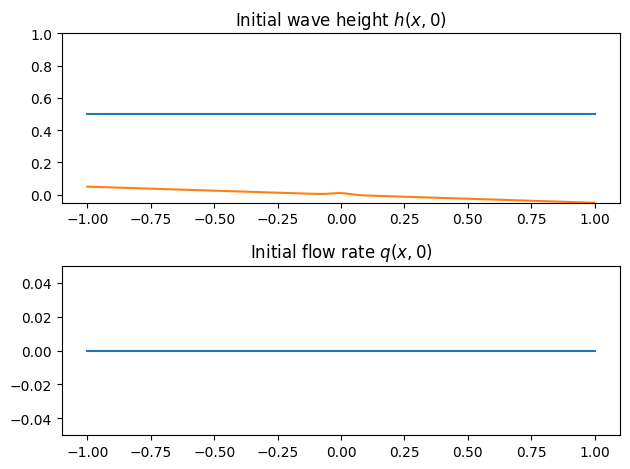

In [3]:
# Enable interactive plots
#
%matplotlib inline

import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

import swe_1d
import fluxes
import quadrature
import rk


# Physical parameters
#
g = 9.81  # gravity
inflow_rate = 0.05

tspan = (0.0, 2.0)
xspan = (-1.0, 1.0)
x_l, x_r = xspan


def initial_condition(xx):
    """
    Creates initial conditions for (h, uh).

    :param xx:
    :return:
    """
    initial_height = 0.5 * np.ones(xx.shape) - swe_bathymetry(xx)  # water at rest
    initial_flow = np.zeros(xx.shape)

    ic = np.array((
        initial_height,
        initial_flow,
    ))

    return ic


eps = 20
amplitude = 0.01


def swe_bathymetry(xx):
    return -0.05 * xx + amplitude * np.exp(-np.square(eps*xx))


def swe_bathymetry_derivative(xx):
    return -0.05 * np.ones(xx.shape) + amplitude * -2*np.square(eps)*xx * np.exp(-np.square(eps*xx))


# Plot bathymetry and ICs
#
XX = np.linspace(x_l, x_r, num=100)
fig, (h_ax, hv_ax) = plt.subplots(2, 1)

ic = initial_condition(XX)
bb = swe_bathymetry(XX)

# Plot bathymetry
#
h_ax.plot(XX, ic[0] + bb)
h_ax.plot(XX, bb)
h_ax.set_ylim([-0.05, 1.0])
h_ax.set_title('Initial wave height $h(x, 0)$')

# Plot flow rate
#
hv_ax.plot(XX, ic[1])
hv_ax.set_ylim([-0.05, 0.05])
hv_ax.set_title('Initial flow rate $q(x, 0)$')

plt.tight_layout()

From here, we'll define our prescribed inflow and free outflow boundary conditions:

In [4]:
print('Creating boundary conditions...')

def q_bc(t):
    """
    Prescribed inflow rate as a function of time

    :param t:
    :return:
    """
    return inflow_rate * t if t < 1 else inflow_rate  # Constant inflow


# Prescribed inflow flux (derived by equating backward characteristics at the leftmost interface)
#
def prescribed_inflow(q_in):
    """
    Maintains a (possibly time-dependent) prescribed rate of flow at the inflow boundary by setting
    backward characteristics for upwinded values and cell values equal at the leftmost boundary.

    :param q_in: A function with time as its single parameter, which should return the rate of flow
                 at a particular time.
    :return:
    """
    def _flux_function(u_l, u_r, xx, t, f, f_prime):
        h_r, q_r = u_r

        # Backward characteristic
        #
        w_b = q_r / h_r - 2 * np.sqrt(g * h_r)

        # Evaluate prescribed bathymetry value at t
        #
        q = q_in(t)

        # We solve for the square root of h to avoid numerical issues with Newton's method
        #
        sqrt_h = optimize.newton(
            lambda hh: q / np.square(hh) - 2 * np.sqrt(g) * hh - w_b,
            x0=np.square(h_r),
            fprime=lambda hh: -2 * q / hh ** 3 - 2 * np.sqrt(g),
            maxiter=500
        )

        h = np.square(sqrt_h)

        return fluxes.lax_friedrichs_flux(np.array((h, q)), u_r, xx, t, f, f_prime)

    return _flux_function


def transmissive_outflow(u_l, u_r, xx, t, f, f_prime):
    """
    Create a transmissive boundary by setting left and right ("ghost") states the same and computing
    corresponding local Lax-Friedrichs flux.

    For details see Section 9.2.5 of the book:
    - Eleuterio F. Toro (2001)
      Shock-Capturing Methods for Free-Surface Shallow Flows
      1st edition
      ISBN 0471987662

    :param u_l:
    :param u_r:
    :param xx:
    :param t:
    :param f:
    :param f_prime:
    :return:
    """
    return fluxes.lax_friedrichs_flux(u_l, u_l, xx, t, f, f_prime)

print('Boundary conditions created!')

Creating boundary conditions...
Boundary conditions created!


...at which point we are now ready to instantiate and run our solver:

Integrating ODE system...
Computing u' at t=0.17873269077576998
Computing u' at t=0.1065803422461831
Computing u' at t=0.21057958817302502
Computing u' at t=0.3170961276925608
Computing u' at t=0.42128498354396965
Computing u' at t=0.5266265845246477
Computing u' at t=0.633116498144827
Computing u' at t=0.738419828490019
Computing u' at t=0.8425859322568905
Computing u' at t=0.9482347136259744
Computing u' at t=1.0530195874936086
Computing u' at t=1.158200058586326
Computing u' at t=1.2632697916961666
Computing u' at t=1.3684943181291995
Computing u' at t=1.4745004677948343
Computing u' at t=1.580121464744847
Computing u' at t=1.6844429137859591
Computing u' at t=1.7899051936566504
Computing u' at t=1.8948746754402646
Writing animation to swe_1d.gif...
Saving animation frame 1/100
Saving animation frame 51/100
Animation written to file! View the animation from the file browser at: swe_1d.gif


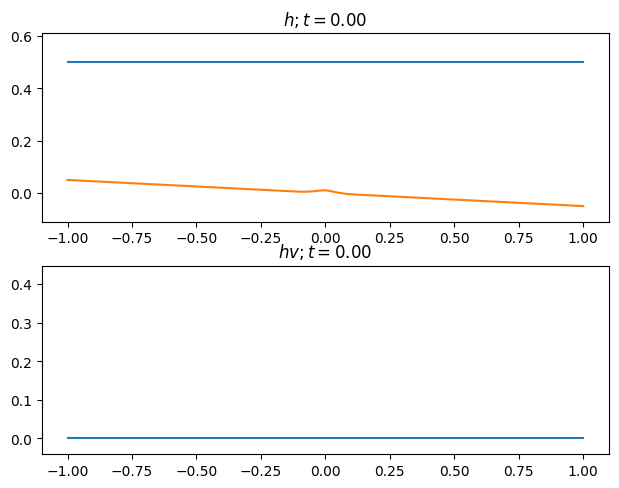

In [5]:
# Instantiate solver with bathymetry
#
solver = swe_1d.ShallowWater1D(
    b=swe_bathymetry,
    b_x=swe_bathymetry_derivative,
    g=g
)


t_interval_ms = 20
dt = t_interval_ms / 1000

print('Integrating ODE system...')
solution = solver.solve(
    tspan=tspan,
    xspan=xspan,
    cell_count=16,
    polydeg=5,
    initial_condition=initial_condition,
    intercell_flux=fluxes.lax_friedrichs_flux,
    left_boundary_flux=prescribed_inflow(q_bc),
    right_boundary_flux=transmissive_outflow,
    quad_rule=quadrature.gll,
    **{
        'method': 'RK45',
        # 'method': rk.SSPRK33,  # Uncomment to use a strong-stability preserving RK method
        't_eval': np.arange(tspan[0], tspan[1], dt),
        'max_step': dt,  # max time step for ODE solver
        'rtol': 1.0e-6,
        'atol': 1.0e-6,

    }
)

ani, plt = solver.plot_animation(solution, frame_interval=t_interval_ms)

movie_name = 'swe_1d.gif'
print('Writing animation to {}...'.format(movie_name))
ani.save(movie_name, progress_callback=lambda i, n: print(f'Saving animation frame {i + 1}/{n}') if i % 50 == 0 else None)
print('Animation written to file! View the animation from the file browser at: {}'.format(movie_name))


![SWE Animation](swe_1d.gif)
